In [1]:
import os
import time

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from fidelity_analysis.mock_file_creator import shift_s2p_freq_axis_minimal
from floquet_analysis.transmon_floquet_simulator import TransmonFloquetSimulator
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
from joblib import Parallel, delayed
from fidelity_analysis.pulse import RectangularReadoutPulse
from fidelity_analysis.fidelity_simulation import FidelitySimulation
from fidelity_analysis.utils import UnitConverter


In [3]:
#TEMPLATE_FILE = "template_0ghz_resonator_cut_wide.s2p"
TEMPLATE_FILE = "data_00000_0_ghz.s2p"
kappa = 0.55 * 1e6 * 2 * np.pi

current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "fidelity_analysis", "data")
images_dir_path = os.path.join(current_path, "images")
template_file_path = os.path.join(data_dir_path, TEMPLATE_FILE)

simulation_path = os.path.join(data_dir_path, time.strftime("%Y%m%d-%H%M%S"))

In [9]:
# Measured frequencies
f01_meas = 3.845965050
f12_meas = 3.602264855
alpha = f12_meas - f01_meas

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [10]:
# Define parameters for the Floquet simulation
Ec = EC_fitted * 2 * np.pi
EjEc = EJ_fitted / EC_fitted
N = 10  # Charge basis truncation

# Define the range of resonator photon numbers
n_r_list_sim = np.linspace(0, 100, 101)
g_strength_sim = g_fitted * 2 * np.pi  # Coupling strength in GHz

ng = np.linspace(0, 0.5, 51)
w_d = np.linspace(4, 12, 201) * 2 * np.pi

state_to_inspect = 1

In [11]:
# Define parameters for the readout pulse
f_pulse = fr0_meas * 10 ** 9  # Hz

pulse_length = 2 * 10 ** (-6)  # s
total_signal_time = 2 * 10 ** (-6)  # s

pulse_samples_number = 2 ** 23

In [12]:
def func_to_parallelize_n_critical(ng_value, w_d_value):
    simulator_tmp = TransmonFloquetSimulator(Ec, EjEc, N, w_d_value, g_strength_sim, n_r_list_sim, ng_value)

    n_critical_for_this_ng = simulator_tmp.find_n_r_critical(state_to_inspect, plot=False)
    state_energy = simulator_tmp.bare_eigenenergies[state_to_inspect + 1] - simulator_tmp.bare_eigenenergies[
        state_to_inspect]
    detuning = (state_energy - w_d_value) / (2 * np.pi)

    return n_critical_for_this_ng, detuning, ng_value


template_specific_shift = 0

all_results = []
all_filtered_results = []
result_min = []
result_min_fidelity = []
result_max = []
for w_d_val in tqdm(w_d,
                    desc="Finding n_r_critical and the corresponding fidelity for different n_g and resonator frequencies"):
    result = Parallel(n_jobs=-1)(
        delayed(func_to_parallelize_n_critical)(ng_val, w_d_val)
        for ng_val in ng
    )
    # remove nans
    result_filtered = [sublist for sublist in result if not any(np.isnan(item) for item in sublist)]

    all_results.append(result)
    all_filtered_results.append(result_filtered)
    if result_filtered:
        results_min_n = min(result_filtered, key=lambda x: x[0])
        result_min.append(results_min_n)
        result_max.append(max(result_filtered, key=lambda x: x[0]))

        n_critical = results_min_n[0]
        delta = results_min_n[1]

        chi = -g_fitted ** 2 / delta * (1 / (1 + delta / alpha))

        file_state_0 = os.path.join(simulation_path, f"{delta}_0.s2p")
        file_state_1 = os.path.join(simulation_path, f"{delta}_1.s2p")
        shift_s2p_freq_axis_minimal(template_file_path, file_state_0, template_specific_shift + chi)
        shift_s2p_freq_axis_minimal(template_file_path, file_state_1, template_specific_shift - chi)

        rect_readout_pulse = RectangularReadoutPulse(
            carrier_frequency=f_pulse,
            pulse_duration=pulse_length,
            # Here I use max(fr0_meas, fr1_meas), so that we look at the bottom edge of the fidelity
            # The number of photons is different for different states also for higher frequency we have lower power
            pulse_power_dbm=UnitConverter().photons_to_dbm(n_critical, max(fr0_meas, fr1_meas) * 1e9, kappa),
            total_signal_time=total_signal_time,
            pulse_samples_number=pulse_samples_number,
        )

        fidelity_simulation = FidelitySimulation(
            s_parameters_file_state_0=file_state_0,
            s_parameters_file_state_1=file_state_1,
            readout_pulse=rect_readout_pulse,
            IQ_projection_frequency=rect_readout_pulse.carrier_frequency + 200e6,  # f_fi = 200MHz
            num_iterations=250,
            readout_dt=1e-9,
            plot_pulses=False,
            plot_result=False,
            disable_progress_bar=True,
        )
        fidelity = fidelity_simulation.run()
        result_min_fidelity.append(fidelity)

result_min_fidelity = np.array(result_min_fidelity)
result_min = np.array(result_min)
result_max = np.array(result_max)

time_string = time.strftime("%Y%m%d-%H%M%S")
filename = f"n_critical_fidelity_wd-5-12-301_n_r_0-300-201-{time_string}.npy"

with open(filename, "wb") as f:
    np.save(f, result_min_fidelity)
    np.save(f, result_min)
    np.save(f, result_max)
    np.save(f, all_results)

n_critical_min = result_min[:, 0]
n_critical_max = result_max[:, 0]

Finding n_r_critical and the corresponding fidelity for different n_g and resonator frequencies:   0%|          | 0/201 [00:00<?, ?it/s]UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
Finding n_r_critical and the corresponding fidelity for different n_g and resonator frequencies: 100%|██████████| 201/201 [4:53:58<00:00, 87.75s/it]   


NameError: name 'time_string' is not defined

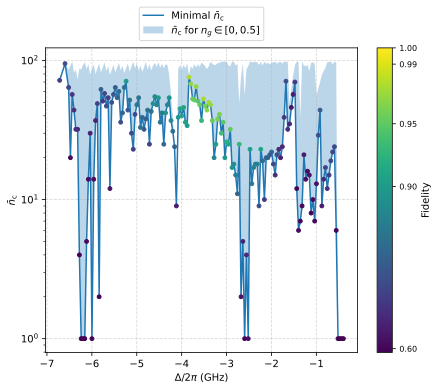

In [4]:
filename = "n_critical_fidelity_wd-5-12-301_n_r_0-300-201-20250805-033644.npy"
with open(filename, "rb") as f:
    result_min_fidelity = np.load(f)
    result_min_loaded = np.load(f)
    result_max_loaded = np.load(f)
    all_results_loaded = np.load(f)


fidelity_min = 0.5
fidelity_max = 1.0
gamma = np.exp(1)

# Normalize fidelity to [0, 1]
fidelity_normalized = (result_min_fidelity - fidelity_min) / (fidelity_max - fidelity_min)
fidelity_normalized = np.clip(fidelity_normalized, 0, 1)

# Apply exponential scaling
fidelity_scaled = fidelity_normalized ** gamma

# Map to color indices
color_indices = (fidelity_scaled * 99).astype(int)
color_indices = np.clip(color_indices, 0, 99)

# Generate colors
cmap = plt.get_cmap('viridis', 100)
colors = cmap(color_indices)


fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True, dpi=300)

axs.set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs.set_ylabel(r'$\bar{n}_\text{c}$')
axs.grid(True, linestyle='--', alpha=0.5)
axs.set_yscale("log")

scatter = axs.scatter(result_min_loaded[:, 1], result_min_loaded[:, 0],
                      color=colors, zorder=10,
                      s=15
                      )
axs.plot(result_min_loaded[:, 1], result_min_loaded[:, 0],
         label=r"Minimal $\bar{n}_\text{c}$",
         )

axs.fill_between(result_min_loaded[:, 1], result_min_loaded[:, 0], result_max_loaded[:, 0], alpha=0.3, label = r"$\bar{n}_\text{c} \; \text{for} \; n_g\in[0, 0.5]$")

# Add the colorbar
cbar = fig.colorbar(scatter, ax=axs)
cbar.set_label(r"Fidelity")

# Set ticks in display fidelity space
tick_values = np.array([0.6, 0.9, 0.95, 0.99, 1.0])
# Convert tick values using same transformation
tick_positions = ((tick_values - fidelity_min) / (fidelity_max - fidelity_min)) ** gamma

cbar.set_ticks(tick_positions)
cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])

for label in cbar.ax.get_yticklabels():
    label.set_fontsize(8)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=1)

plt.savefig(os.path.join(images_dir_path, f"detuning_nc_with_ng_{time_string}_exp.png"))
plt.show()

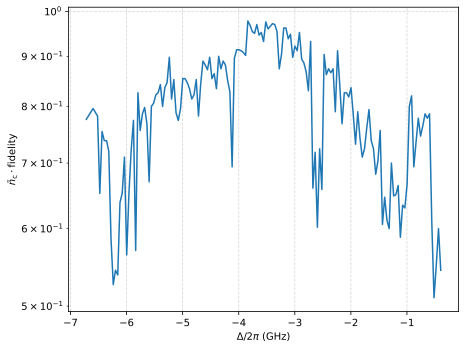

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True, dpi=300)

axs.set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs.set_ylabel(r'$\bar{n}_\text{c} \cdot \text{fidelity}$')
axs.grid(True, linestyle='--', alpha=0.5)
axs.set_yscale("log")


axs.plot(result_min_loaded[:, 1], result_min_loaded[:, 0]*result_min_fidelity)#result_min_loaded[:, 0]*np.where(result_min_fidelity>0.9999, 1, 0))

plt.savefig(f"detuning_nc_with_ng_{time_string}.png")
plt.show()

In [15]:
result_min_fidelity


array([0.544, 0.6  , 0.55 , 0.51 , 0.61 , 0.786, 0.778, 0.786, 0.764,
       0.746, 0.778, 0.736, 0.694, 0.82 , 0.8  , 0.666, 0.63 , 0.634,
       0.588, 0.664, 0.65 , 0.648, 0.7  , 0.6  , 0.612, 0.646, 0.606,
       0.756, 0.704, 0.682, 0.724, 0.738, 0.794, 0.76 , 0.724, 0.71 ,
       0.742, 0.79 , 0.732, 0.784, 0.836, 0.818, 0.826, 0.826, 0.768,
       0.84 , 0.912, 0.79 , 0.874, 0.866, 0.874, 0.862, 0.904, 0.658,
       0.724, 0.602, 0.718, 0.66 , 0.932, 0.83 , 0.868, 0.886, 0.894,
       0.952, 0.912, 0.922, 0.898, 0.948, 0.938, 0.962, 0.962, 0.904,
       0.874, 0.954, 0.97 , 0.972, 0.966, 0.96 , 0.976, 0.932, 0.952,
       0.946, 0.97 , 0.95 , 0.954, 0.968, 0.978, 0.902, 0.908, 0.912,
       0.914, 0.914, 0.896, 0.694, 0.828, 0.85 , 0.882, 0.89 , 0.874,
       0.9  , 0.834, 0.864, 0.854, 0.898, 0.872, 0.882, 0.89 , 0.844,
       0.782, 0.852, 0.822, 0.814, 0.834, 0.846, 0.854, 0.854, 0.796,
       0.774, 0.788, 0.852, 0.814, 0.898, 0.846, 0.836, 0.8  , 0.842,
       0.826, 0.822,